In [1]:
import cv2
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage.filters import uniform_filter

In [2]:
def get_non_uniform_sampling(source, steps):
    shape = np.shape(source)
    height = shape[0]
    length = shape[1]
    
    x_centre = int(length/2)
    y_centre = int(height/2)
    radius = int(min(length, height)/2)
    
    pi = np.pi
    multiplier = 0.5
    x_coordinates = []
    y_coordinates = []

    for r in steps:
        number_of_points = (1/multiplier) * 2

        for j in range(int(number_of_points)):
            theta = j*pi*multiplier
            x = x_centre + (r * np.cos(theta))
            y = y_centre + (r * np.sin(theta))
            
            if(x<length and x>0 and y<height and y>0):
                x_coordinates.append(int(x))
                y_coordinates.append(int(y))

        multiplier = multiplier/2
    
    return x_coordinates, y_coordinates


# def window_stdev(X, window_size):
#     c1 = uniform_filter(X, window_size, mode='reflect')
#     c2 = uniform_filter(X*X, window_size, mode='reflect')
#     return np.sqrt(c2 - c1*c1)

In [3]:
img = cv2.imread("OS0056EY.JPG")
print(np.shape(img))
(B,G,R) = cv2.split(img)
cv2.imshow("Source Image", B)
cv2.waitKey(0)

(1248, 1664, 3)


-1

In [4]:
steps = [40, 150, 275, 450, 610]
x_coordinates, y_coordinates = get_non_uniform_sampling(G, steps)
number_of_points = (np.shape(x_coordinates))[0]
print("The number of points is", number_of_points)

The number of points is 124


Text(0.5, 1.0, 'Image and Sampling Points')

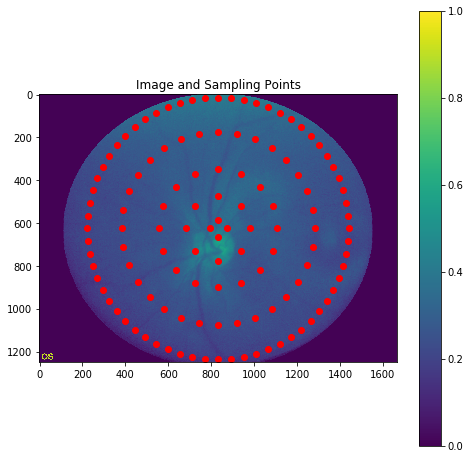

In [5]:
plt.figure(figsize = (8,8))
plt.imshow(G)
plt.scatter(x_coordinates, y_coordinates, color='red')
plt.colorbar()
plt.title("Image and Sampling Points")

In [6]:
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
# gradient = cv2.morphologyEx(G, cv2.MORPH_GRADIENT, kernel)

# plt.figure(figsize = (8,8))
# plt.imshow(gradient)
# plt.colorbar()
# plt.title("Border")

In [7]:
def get_roi_values(src, x , y, window_size):
    height = np.shape(img)[0]
    length = np.shape(img)[1]
    
    left = x - int(window_size/2)
    left = max(0, left)
    
    right = x + int(window_size/2)
    right = min(length, right)
    
    top = y - int(window_size/2)
    top = max(0, top)
    
    bottom = y + int(window_size/2)
    bottom = min(height, bottom)
    
    slice_arr = src[top:bottom, left:right]
    
    return slice_arr, np.mean(slice_arr), np.std(slice_arr)

def get_mean_std(src, x_coordinates, y_coordinates, window_size):
    mean = []
    std = []
    number_of_points = np.shape(x_coordinates)[0]
    
    for i in range(number_of_points):
        slice_arr, slice_mean, slice_std = get_roi_values(src, x_coordinates[i], y_coordinates[i], window_size)
        mean.append(slice_mean)
        std.append(slice_std)
    
    return mean, std

In [8]:
mean, std = get_mean_std(G, x_coordinates, y_coordinates, 50)

In [9]:
# image_window_size = 50
# G_mean = cv2.blur(G, (image_window_size, image_window_size))
# G_mean = np.array(G_mean, dtype=np.float32)

# plt.figure(figsize = (8,8))
# plt.imshow(G_mean)
# plt.colorbar()
# plt.title("Mean of Image")

In [10]:
# G_std = window_stdev(G, image_window_size)
# G_std = np.array(G_std, dtype=np.float32)

# plt.figure(figsize = (8,8))
# plt.imshow(G_std)
# plt.colorbar()
# plt.title("Standard Deviation of Image")

In [11]:
# mean = np.empty(number_of_points)
# std = np.empty(number_of_points)

# for i in range(number_of_points):
#     x = x_coordinates[i]
#     y = y_coordinates[i]
    
#     mean[i] = G_mean[y, x]
#     std[i] = G_std[y, x]

In [12]:
xi = np.arange(0, np.shape(G)[1], 1)
yi = np.arange(0, np.shape(G)[0], 1)
x_grid, y_grid = np.meshgrid(xi, yi)

points = []
for i , j in zip(x_coordinates, y_coordinates):
    points.append([i,j])

Text(0.5, 1.0, 'Interpolated Mean')

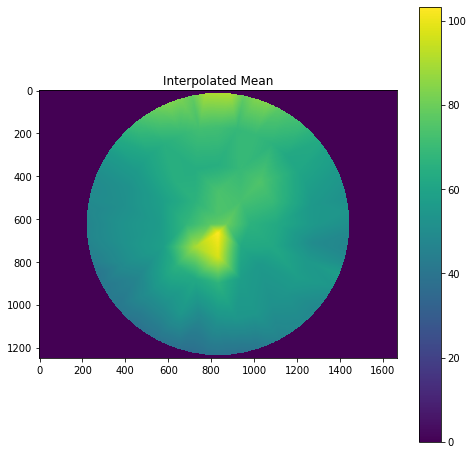

In [13]:
interpolated_mean = scipy.interpolate.griddata(points, mean, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_mean)
plt.colorbar()
plt.title("Interpolated Mean")

Text(0.5, 1.0, 'Interpolated Standard Deviation')

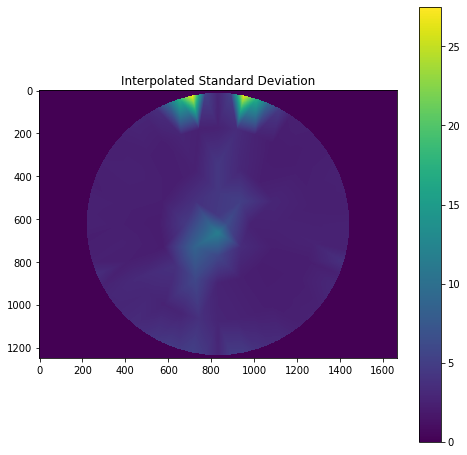

In [14]:
interpolated_std = scipy.interpolate.griddata(points, std, (x_grid, y_grid) , method='linear', fill_value=0, rescale=False)

plt.figure(figsize = (8,8))
plt.imshow(interpolated_std)
plt.colorbar()
plt.title("Interpolated Standard Deviation")

C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0.5, 1.0, 'Mahalanobis Distance')

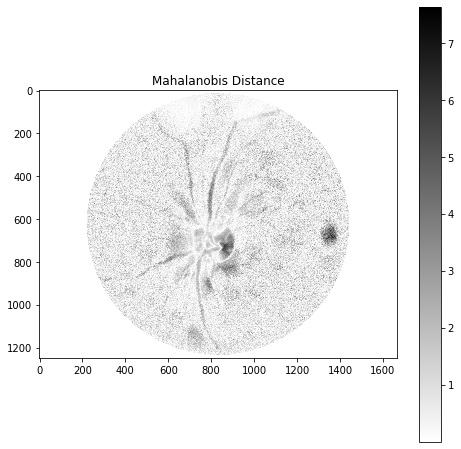

In [15]:
height = np.shape(G)[0]
length = np.shape(G)[1]

mahalanobis = np.empty(np.shape(G))
background = np.zeros(np.shape(G))

G = np.array(G)
interpolated_mean = np.array(interpolated_mean)
interpolated_std = np.array(interpolated_std)

mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
plt.figure(figsize = (8,8))
plt.imshow(mahalanobis, cmap='binary')
plt.colorbar()
plt.title("Mahalanobis Distance")

In [16]:
for i in range(height):
    for j in range(length):
        if(mahalanobis[i, j] <= 1):
            background[i, j] = 1

Text(0.5, 1.0, 'Background')

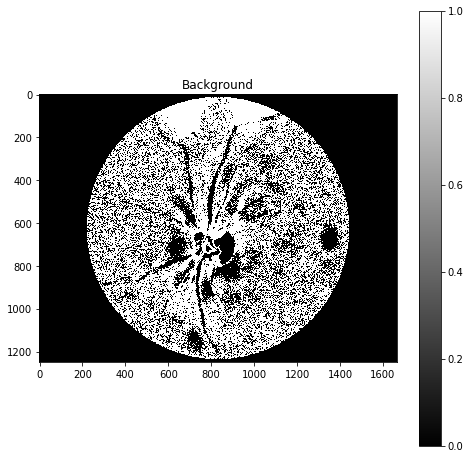

In [17]:
plt.figure(figsize = (8,8))
plt.imshow(background, cmap="binary_r")
plt.colorbar()
plt.title("Background")

(1248, 1664)
uint8


Text(0.5, 1.0, 'Mult')

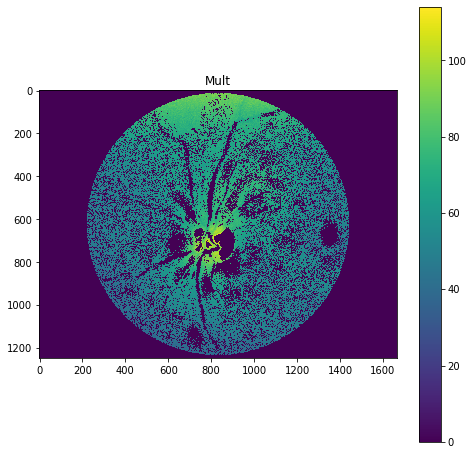

In [18]:
background = np.array(background)
G = np.array(G)
mult = background*G
print(mult.shape)

mult= mult.astype(np.uint8)
print(mult.dtype)
#mult =cv2.cvtColor(mult, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (8,8))
plt.imshow(mult)
plt.colorbar()
plt.title("Mult")

In [19]:
background_window_size = 125

In [20]:
x_white = np.where(background==1)[1]
y_white = np.where(background==1)[0]

print(np.shape(x_white)[0])

769377


In [21]:
# background_window_size = 125
# SA = cv2.blur(background, (background_window_size, background_window_size))
# SM = window_stdev(background, background_window_size)

In [22]:
x_all = np.arange(0, length , 1)
y_all = np.arange(0, height , 1)

print(x_all)
print(y_all)

[   0    1    2 ... 1661 1662 1663]
[   0    1    2 ... 1245 1246 1247]


In [23]:
mean_mult = []
std_mult = []
number_of_points = np.shape(x_all)[0]
number_of_points_y = np.shape(y_all)[0]
window_size = 125
  
for i in range(length):
    for j in range(height):
        mult_slice, temp_mean, temp_std = get_roi_values(mult, i , j, window_size)
        mult_slice = mult_slice[(mult_slice != 0)]
        #print(mult_slice.size)
        if(not np.any(mult_slice)):
            mean_mult.append(0) 
            std_mult.append(0)
        else:
            mean_m = np.mean(mult_slice)
            std_m = np.std(mult_slice)
            mean_mult.append(mean_m)
            std_mult.append(std_m)

In [24]:
# mean_mult = []
# std_mult = []
# number_of_points = np.shape(x_white)[0]
# window_size = 125
  
# for i in range(number_of_points):
#     mult_slice, temp_mean, temp_std = get_roi_values(mult, x_white[i] , y_white[i], window_size)
#     mult_slice = mult_slice[mult_slice != 0]
#     mean_m = np.mean(mult_slice)
#     std_m = np.std(mult_slice)
#     mean_mult.append(mean_m)
#     std_mult.append(std_m)

In [25]:
# points_bg = []
# for i, j in zip(x_white, y_white):
#     points_bg.append([i,j])

In [26]:
# interpolated_meanmult = scipy.interpolate.griddata(points_bg, mean_mult, (x_grid, y_grid) , method='linear', 
#                                                    fill_value=0, rescale=False)

# plt.figure(figsize = (8,8))
# plt.imshow(interpolated_meanmult, cmap='jet')
# plt.colorbar()

In [27]:
# interpolated_stdmult = scipy.interpolate.griddata(points_bg, std_mult, (x_grid, y_grid) , method='linear', 
#                                                   fill_value=0, rescale=False)

# plt.figure(figsize = (8,8))
# plt.imshow(interpolated_stdmult, cmap='jet')
# plt.colorbar()

In [30]:
U = np.empty(np.shape(G))
SM = np.array(mean_mult)
SA = np.array(std_mult)
SM = SM.reshape(height,length,  order='F')
SA = SA.reshape( height, length, order='F')
U = (G - SM) / SA

C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'U')

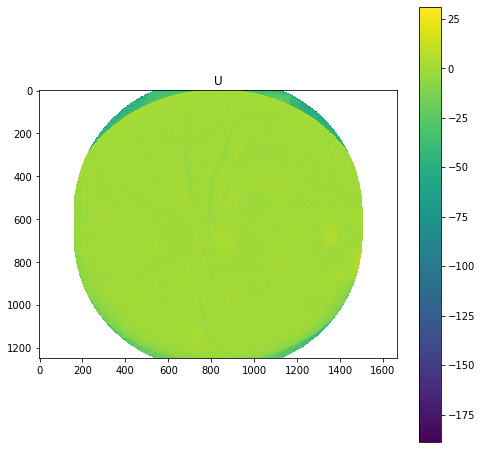

In [31]:
plt.figure(figsize = (8,8))
plt.imshow(U)
plt.colorbar()
plt.title("U")

Text(0.5, 1.0, 'U')

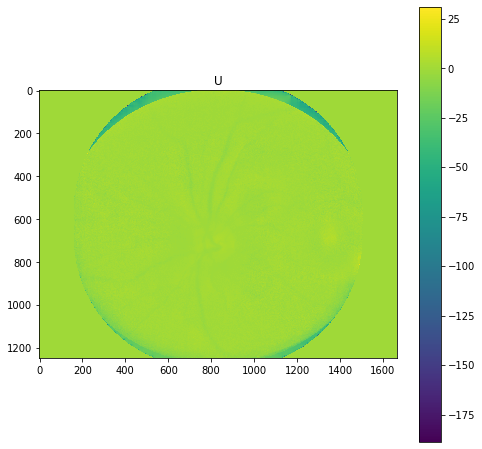

In [32]:
U[np.isnan(U)] = 0
U[~np.isfinite(U)] = 0
plt.figure(figsize = (8,8))
plt.imshow(U)
plt.colorbar()
plt.title("U")

Text(0.5, 1.0, 'U norm')

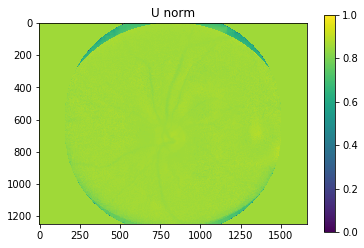

In [33]:
U_norm = (U - np.min(U))/(np.max(U)- np.min(U))
plt.imshow(U_norm)
plt.colorbar()
plt.title("U norm")

Text(0.5, 1.0, 'SM')

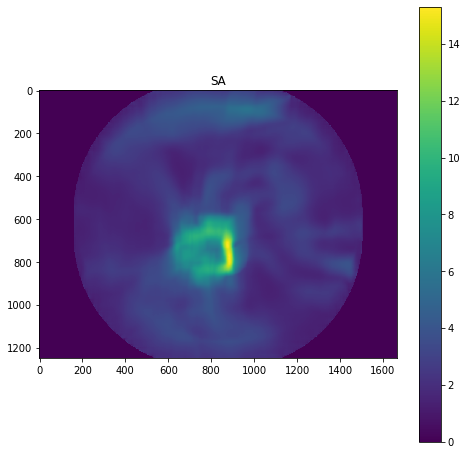

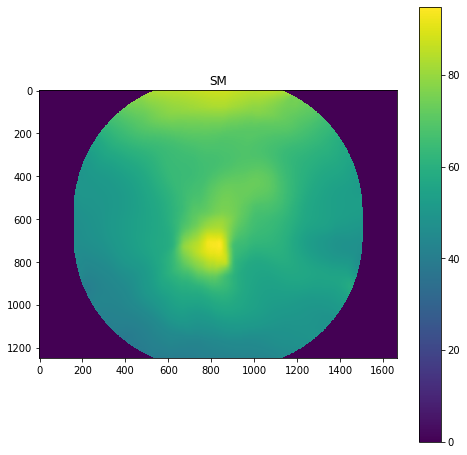

In [34]:
plt.figure(figsize = (8,8))
plt.imshow(SA)
plt.colorbar()
plt.title("SA")

plt.figure(figsize = (8,8))
plt.imshow(SM)
plt.colorbar()
plt.title("SM")

In [35]:
# plt.figure(figsize = (8,8))
# plt.imshow(R)
# plt.colorbar()
# plt.title("R plane")

# plt.figure(figsize = (8,8))
# plt.imshow(G)
# plt.colorbar()
# plt.title("G plane")

# plt.figure(figsize = (8,8))
# plt.imshow(B)
# plt.colorbar()
# plt.title("B plane")

C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys
C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  
C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\Shalaka-Deshpande\Anacondapython\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Text(0.5, 1.0, 'Corrected B plane')

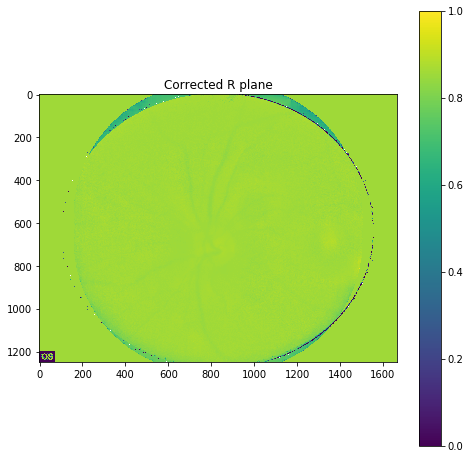

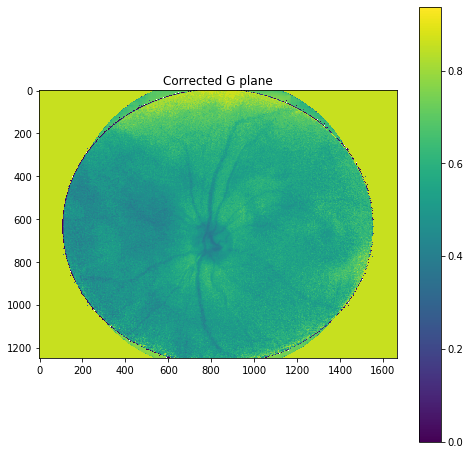

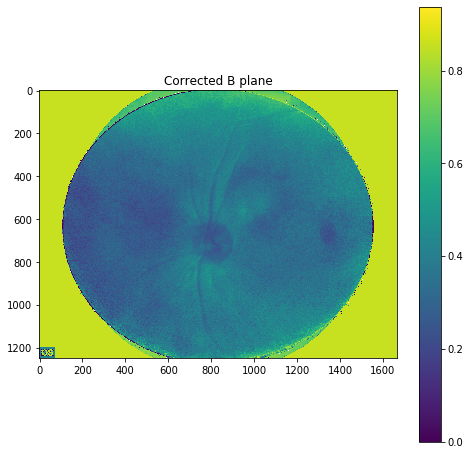

In [36]:
v = np.empty(np.shape(G))
R = np.array(R)
G = np.array(G)
B = np.array(B)

v = np.maximum(np.maximum(R,G),B)
R_corr = (U_norm/v)*R
G_corr = (U_norm/v)*G
B_corr = (U_norm/v)*B

plt.figure(figsize = (8,8))
plt.imshow(R_corr)
plt.colorbar()
plt.title("Corrected R plane")

plt.figure(figsize = (8,8))
plt.imshow(G_corr)
plt.colorbar()
plt.title("Corrected G plane")

plt.figure(figsize = (8,8))
plt.imshow(B_corr)
plt.colorbar()
plt.title("Corrected B plane")

In [37]:
R_corr[np.isnan(R_corr)] =0
G_corr[np.isnan(G_corr)] =0
B_corr[np.isnan(B_corr)] =0

Final_image = cv2.merge([B_corr, G_corr, R_corr])
#Final_image= Final_image.astype(np.uint8)

In [38]:
cv2.namedWindow('Enhanced Image', cv2.WINDOW_NORMAL)
cv2.imshow("Enhanced Image", Final_image)
print(Final_image.dtype)
cv2.waitKey(0)

float64


-1

In [ ]:
print(Final_image.shape)
print(Final_image.dtype)

In [ ]:
# Final_image = cv2.cvtColor(Final_image, cv2.COLOR_BGR2RGB)
# cv2.namedWindow('Enhanced Image', cv2.WINDOW_NORMAL)
# cv2.imshow("Enhanced Image", Final_image)
# print(Final_image.dtype)
# cv2.waitKey(0)

In [ ]:
rgb_image = cv2.cvtColor(Final_image, cv2.COLOR_BGR2RGB)


In [ ]:
cv2.imshow("Enhanced Image", rgb_image)
print(Final_image.dtype)
cv2.waitKey(0)